**Name:** Jay Bharambe

**Roll No:** 22159

**GitHub:** https://github.com/jayb71

Note- Need to change the runtime type to T4-GPU, normal CPUs take exceptionally large time.

In [ ]:
!pip install gensim

In [ ]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec, KeyedVectors
import matplotlib.pyplot as plt


In [ ]:

!git clone https://github.com/islnlp/Assignment_1_2025 datasets


Cloning into 'datasets'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.06 MiB | 11.80 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
def generate_word2vec_embeddings(task, data_path="datasets", output_path="."):
    train_df = pd.read_csv(f"{data_path}/{task}/train.csv")
    sentences = train_df["Sentence"].apply(lambda x: x.split()).tolist()

    model = Word2Vec(sentences=sentences, vector_size=100, window=2, min_count=1, sg=1, epochs=10)

    word_vectors = model.wv
    vectors = np.array([word_vectors[word] for word in word_vectors.index_to_key])
    np.save(f"{output_path}/word_embeddings_{task}_1.npy", vectors)
    word_vectors.save(f"{output_path}/word2vec_{task}.kv")
    model.save(f"{output_path}/word2vec_{task}_model.model")

# save embeddings for each task
for task in ["hate", "humor", "sarcasm"]:
    generate_word2vec_embeddings(task)


In [ ]:
def sentence_embedding(sentence, word_to_index, word_embeddings, max_len=50):
    words = sentence.split()
    valid_embeddings = [word_embeddings[word_to_index[word]] for word in words if word in word_to_index]
    if len(valid_embeddings) == 0:
        return np.zeros((max_len, word_embeddings.shape[1]))
    if len(valid_embeddings) > max_len:
        valid_embeddings = valid_embeddings[:max_len]
    else:
        padding = [np.zeros(word_embeddings.shape[1])] * (max_len - len(valid_embeddings))
        valid_embeddings.extend(padding)
    return np.array(valid_embeddings)

class TextDataset(Dataset):
    def __init__(self, data, word_to_index, word_embeddings, max_len=50):
        self.sentences = data["Sentence"].tolist()
        self.labels = data["Tag"].tolist()
        self.word_to_index = word_to_index
        self.word_embeddings = word_embeddings
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence_vector = sentence_embedding(self.sentences[idx], self.word_to_index, self.word_embeddings, self.max_len)
        label = self.labels[idx]
        return torch.tensor(sentence_vector, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim * 50, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, bidirectional=False):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, num_layers=n_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        _, hidden = self.rnn(x)
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        return self.fc(self.dropout(hidden))

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=n_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        return self.fc(self.dropout(hidden))

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, nhead=4, num_layers=2):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x).permute(1, 0, 2)
        x = self.encoder(x).mean(dim=0)
        return self.fc(self.dropout(x))

class BERTClassifier(nn.Module):
    def __init__(self, output_dim=2):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(outputs.pooler_output)
        return self.fc(pooled)


In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, dict):  # BERT
                input_ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                outputs = model(input_ids, mask)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return acc, prec, rec, f1

class BERTDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.sentences = data["Sentence"].tolist()
        self.labels = data["Tag"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.sentences)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.sentences[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

def run_all_models(task):
    train_df = pd.read_csv(f"datasets/{task}/train.csv")
    val_df = pd.read_csv(f"datasets/{task}/val.csv")

    word_embeddings = np.load(f"word_embeddings_{task}_1.npy")
    word_vectors = KeyedVectors.load(f"word2vec_{task}.kv", mmap='r')
    word_to_index = {word: i for i, word in enumerate(word_vectors.index_to_key)}

    train_ds = TextDataset(train_df, word_to_index, word_embeddings)
    val_ds = TextDataset(val_df, word_to_index, word_embeddings)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    output_dim = len(set(train_df["Tag"]))
    models = {
        "FFNN": FFNN(100, 64, output_dim),
        "RNN": RNNClassifier(100, 64, output_dim),
        "LSTM": LSTMClassifier(100, 64, output_dim),
        "Bi-LSTM": LSTMClassifier(100, 64, output_dim, bidirectional=True),
        "Transformer": TransformerClassifier(100, 64, output_dim)
    }

    results = {}
    for name, model in models.items():
        model.to(device)
        # Training part and also saving the weights
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()
        # for epoch in range(5):  # training loop
        #     model.train()
        #     for x, y in train_loader:
        #         x, y = x.to(device), y.to(device)
        #         optimizer.zero_grad()
        #         loss = criterion(model(x), y)
        #         loss.backward()
        #         optimizer.step()
        # torch.save(model.state_dict(), f"{task}_{name}.pth")

        # # Load trained weights:
        # model.load_state_dict(torch.load(f"{task}_{name}.pth", map_location=device))
        results[name] = dict(zip(["Accuracy", "Precision", "Recall", "F1"],
                                 evaluate_model(model, val_loader, device)))

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BERTClassifier(output_dim=output_dim).to(device)
    val_bert_loader = DataLoader(BERTDataset(val_df, tokenizer), batch_size=32)

    # BERT model Training
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    train_bert_loader = DataLoader(BERTDataset(train_df, tokenizer), batch_size=32, shuffle=True)
    bert_model = BERTClassifier(output_dim=output_dim).to(device)
    optimizer = optim.Adam(bert_model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()

    # for epoch in range(3):
    #     bert_model.train()
    #     total_loss = 0
    #     for batch in train_bert_loader:
    #         input_ids = batch['input_ids'].to(device)
    #         mask = batch['attention_mask'].to(device)
    #         labels = batch['label'].to(device)

    #         optimizer.zero_grad()
    #         outputs = bert_model(input_ids, mask)
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()
    #         total_loss += loss.item()
    #     print(f"[BERT Epoch {epoch+1}] Loss: {total_loss:.4f}")

    # torch.save(bert_model.state_dict(), f"{task}_BERT.pth")

    # bert_model.load_state_dict(torch.load(f"{task}_BERT.pth", map_location=device))
    results["BERT"] = dict(zip(["Accuracy", "Precision", "Recall", "F1"],
                               evaluate_model(bert_model, val_bert_loader, device)))
    return results

# Run this for each task
all_results = {task: run_all_models(task) for task in ["hate", "humor", "sarcasm"]}


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

[BERT Epoch 1] Loss: 72.9377
[BERT Epoch 2] Loss: 66.3483
[BERT Epoch 3] Loss: 58.7868


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[BERT Epoch 1] Loss: 49.3864
[BERT Epoch 2] Loss: 44.8052
[BERT Epoch 3] Loss: 41.9225


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: Undef

[BERT Epoch 1] Loss: 22.7771
[BERT Epoch 2] Loss: 14.3706
[BERT Epoch 3] Loss: 12.3289


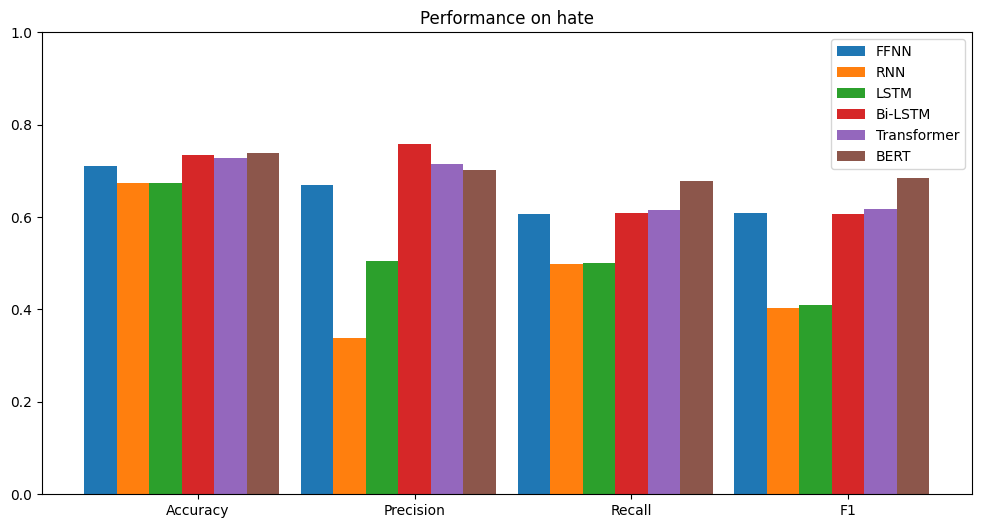

             Accuracy  Precision    Recall        F1
FFNN         0.711160   0.668773  0.606862  0.609705
RNN          0.673961   0.337719  0.498382  0.402614
LSTM         0.673961   0.504772  0.500142  0.408982
Bi-LSTM      0.735230   0.758251  0.608819  0.605599
Transformer  0.728665   0.713863  0.614526  0.616694
BERT         0.739606   0.701457  0.677184  0.685191


In [ ]:
def plot_results(results, task):
    models = list(results.keys())
    metrics = ["Accuracy", "Precision", "Recall", "F1"]
    x = np.arange(len(metrics))
    width = 0.15

    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models):
        values = [results[model][m] for m in metrics]
        plt.bar(x + i * width, values, width, label=model)

    plt.xticks(x + width * (len(models) / 2), metrics)
    plt.ylim(0, 1)
    plt.title(f"Performance on {task}")
    plt.legend()
    plt.show()

plot_results(all_results["hate"], "hate")
print(pd.DataFrame(all_results["hate"]).T)


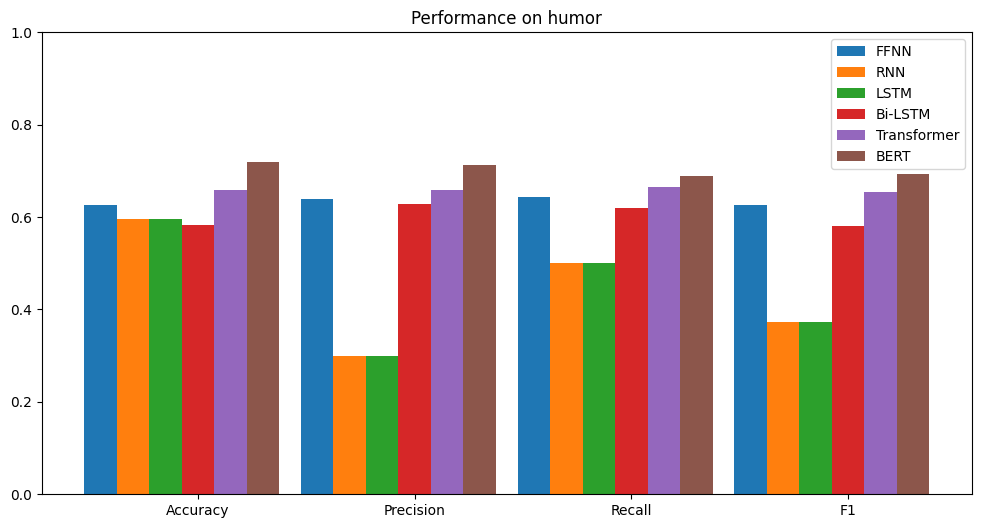

             Accuracy  Precision    Recall        F1
FFNN         0.627119   0.638804  0.642595  0.626393
RNN          0.596610   0.298305  0.500000  0.373673
LSTM         0.596610   0.298305  0.500000  0.373673
Bi-LSTM      0.583051   0.628736  0.619270  0.581126
Transformer  0.657627   0.657956  0.664080  0.654515
BERT         0.718644   0.712358  0.689362  0.693819


In [ ]:
plot_results(all_results["humor"], "humor")
print(pd.DataFrame(all_results["humor"]).T)

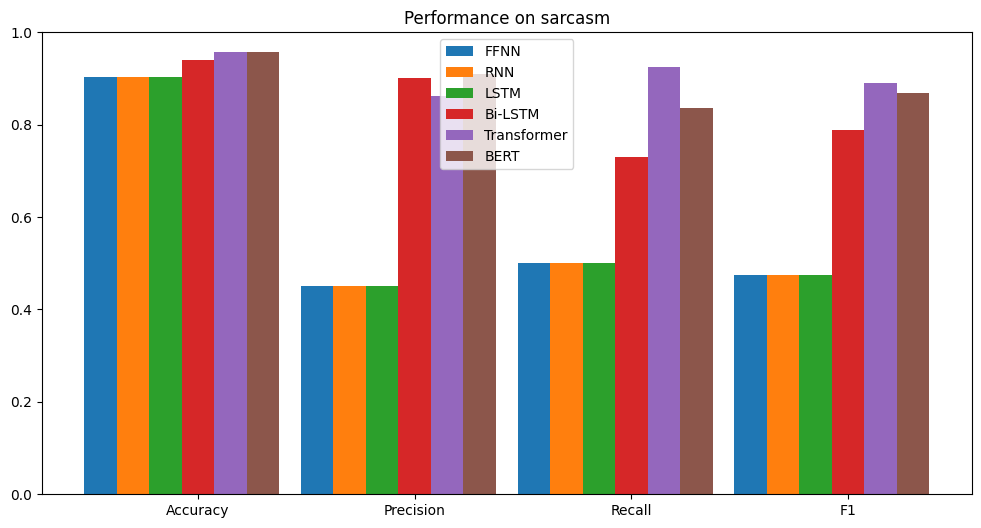

             Accuracy  Precision    Recall        F1
FFNN         0.902857   0.451429  0.500000  0.474474
RNN          0.902857   0.451429  0.500000  0.474474
LSTM         0.902857   0.451429  0.500000  0.474474
Bi-LSTM      0.940952   0.901408  0.731075  0.787835
Transformer  0.958095   0.862387  0.924299  0.890059
BERT         0.958095   0.910300  0.836808  0.868953


In [ ]:
plot_results(all_results["sarcasm"], "sarcasm")
print(pd.DataFrame(all_results["sarcasm"]).T)